In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange 
from typing import List
import random
import math
import json
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import torch.optim as optim
import numpy as np
from PIL import Image

In [2]:
from image_processing import prep_dataset, thresholding

In [3]:
img_paths, _ = prep_dataset.load_img_paths("circle_data")

In [4]:
IMG_SIZE = 64

In [5]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim)
        embeddings[:, 0::2] = torch.sin(position * div_term)
        embeddings[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('embeddings', embeddings)

    def forward(self, t):
        embeds = self.embeddings[t]
        return embeds 

In [6]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float, embed_dim: int):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)
        self.embed_fc = nn.Linear(embed_dim, C)

    def forward(self, x, embeddings):
        emb = embeddings.squeeze(-1).squeeze(-1) 
        emb = self.embed_fc(emb) 
        emb = emb.unsqueeze(-1).unsqueeze(-1)  
        x = x + emb  
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [7]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        b, c, h, w = x.size()
        x = rearrange(x, 'b c h w -> b (h w) c') 
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H L C -> b L (H C)')
        x = self.proj2(x)
        x = rearrange(x, 'b (h w) C -> b C h w', h=h, w=w)
        return x

In [8]:
class UnetLayer(nn.Module):
    def __init__(self, upscale: bool, attention: bool, num_groups: int, dropout_prob: float, num_heads: int, C: int, embed_dim: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob, embed_dim=embed_dim)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob, embed_dim=embed_dim)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C // 2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C * 2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [9]:
class UNET(nn.Module):
    def __init__(self,
                 Channels: List = [64, 128, 256, 512, 512, 384],
                 Attentions: List = [False, True, False, False, False, True],
                 Upscales: List = [False, False, False, True, True, True],
                 num_groups: int = 32,
                 dropout_prob: float = 0.1,
                 num_heads: int = 8,
                 input_channels: int = 1,
                 output_channels: int = 1,
                 time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        embed_dim = max(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        self.time_embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=embed_dim)
        self.binder_fc = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU()
        )
        self.porosity_fc = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU()
        )

        self.combine_fc = nn.Sequential(
            nn.Linear(embed_dim * 3, embed_dim),  
            nn.ReLU()
        )

        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads,
                embed_dim=embed_dim  
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, binder_fraction, porosity, t):
        x = self.shallow_conv(x)
        residuals = []
        device = x.device
        time_embed = self.time_embeddings(t)  
        binder_fraction = binder_fraction.to(device)
        binder_embed = self.binder_fc(binder_fraction) 
        porosity = porosity.to(device)
        porosity_embed = self.porosity_fc(porosity) 

        combined_embed = torch.cat([time_embed, binder_embed, porosity_embed], dim=-1)
        combined_embed = self.combine_fc(combined_embed).unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, embed_dim, 1, 1]

        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i+1}')
            x, r = layer(x, combined_embed)
            residuals.append(r)
        for i in range(self.num_layers // 2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x_new, _ = layer(x, combined_embed)
            x = torch.cat((x_new, residuals[self.num_layers - i - 1]), dim=1)

        x = self.late_conv(self.relu(x))
        x = self.output_conv(self.relu(x))
        return x


In [10]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [11]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [12]:
class PBXDataset(torch.utils.data.Dataset):
    def __init__(self, img_pathlist, transform=None):
        self.img_pathlist = img_pathlist
        self.transform = transform
        random.shuffle(img_pathlist)  
        
    def __len__(self):
        return len(self.img_pathlist)

    def __getitem__(self, idx):
        img_path = self.img_pathlist[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        np_img = image.numpy().squeeze()  # [1, 128, 128]
        
        black_pixels = (np_img <= -0.5).astype(np.uint8)  
        white_pixels = (np_img >= 0.5).astype(np.uint8)  
        gray_pixels = ((np_img > -0.5) & (np_img < 0.5)).astype(np.uint8)  

        black_pixel_count = np.sum(black_pixels == 1)
        total_pixels = np_img.size
        binder_fraction = black_pixel_count / total_pixels

        white_pixel_count = np.sum(white_pixels == 1)
        gray_pixel_count = np.sum(gray_pixels == 1)

        if gray_pixel_count > 0:
            porosity = gray_pixel_count / (white_pixel_count + gray_pixel_count)
        else:
            porosity = 0  

        binder_fraction_tensor = torch.tensor([binder_fraction], dtype=torch.float32)
        porosity_tensor = torch.tensor([porosity], dtype=torch.float32)

        return image, binder_fraction_tensor, porosity_tensor
        
def load_transformed_dataset(img_paths):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(),  
        transforms.ToTensor(), 
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]
    data_transform = transforms.Compose(data_transforms)

    train_dataset = PBXDataset(
        img_paths,
        transform=data_transform,
    )

    return train_dataset

train_dataset = load_transformed_dataset(img_paths)


In [13]:
def show_images_with_binder_fraction_and_porosity(dataset, num_samples=20, cols=4):
    """ Plots samples from the dataset, including binder fractions and porosities """
    fig = plt.figure(figsize=(7, 13))
    for i, (img, binder_fraction, porosity) in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        fig.subplots_adjust(hspace=0.025, wspace=0.025)  
        plt.imshow(img[0], cmap='gray', vmin=-1, vmax=1)
        
        plt.title(f"Binder: {binder_fraction.item():.2f}\nPorosity: {porosity.item():.2f}", fontsize=8)
        plt.axis('off')

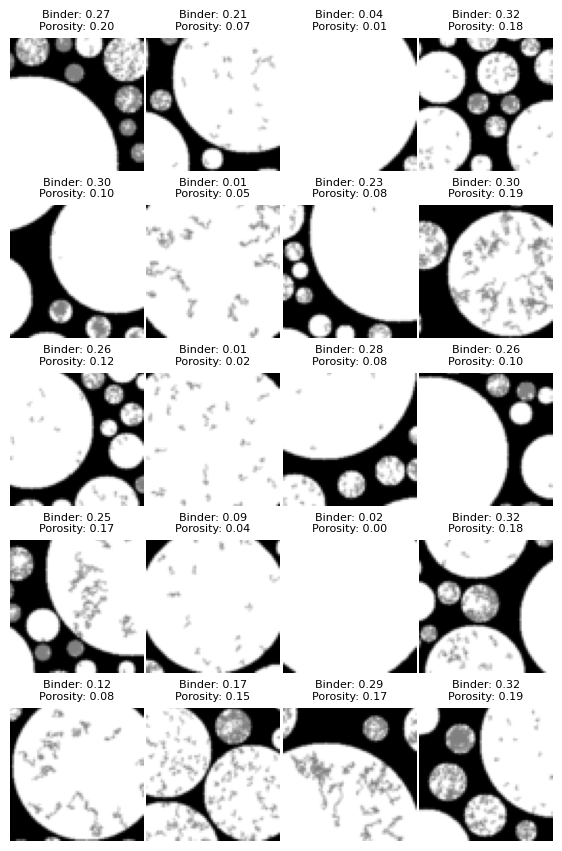

In [14]:
show_images_with_binder_fraction_and_porosity(train_dataset)

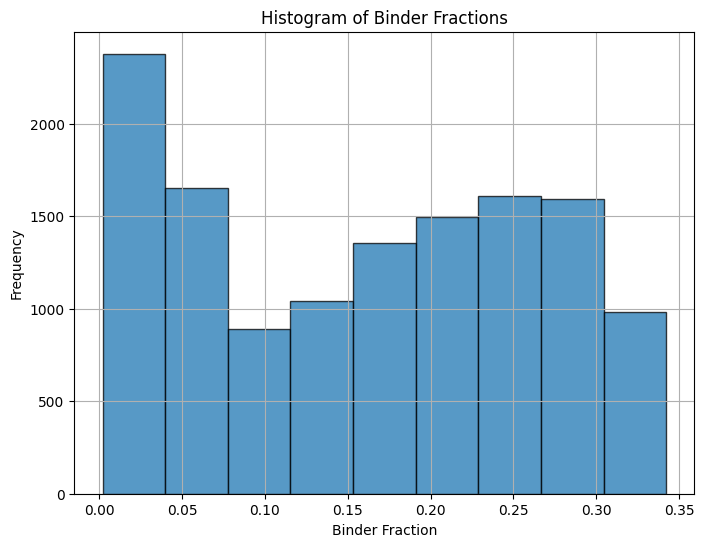

In [15]:
def plot_binder_fraction_histogram(dataset, num_bins=9):
    """ Extracts binder fractions and plots a histogram """
    binder_fractions = []

    for i, (img, binder_fraction, porosity) in enumerate(dataset):
        binder_fractions.append(binder_fraction.item())

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(binder_fractions, bins=num_bins, edgecolor='black', alpha=0.75)
    plt.title('Histogram of Binder Fractions')
    plt.xlabel('Binder Fraction')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_binder_fraction_histogram(train_dataset)

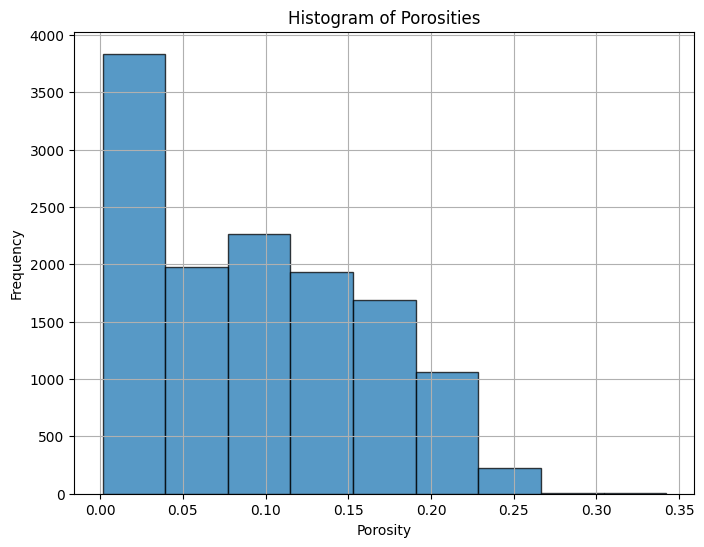

In [16]:
def plot_porosity_histogram(dataset, num_bins=9):
    """ Extracts binder fractions and plots a histogram """
    porosities = []

    for i, (img, binder_fraction, porosity) in enumerate(dataset):
        porosities.append(porosity.item())

    plt.figure(figsize=(8, 6))
    plt.hist(porosities, bins=num_bins, edgecolor='black', alpha=0.75)
    plt.title('Histogram of Porosities')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_porosity_histogram(train_dataset)

In [17]:
model = UNET()

In [18]:
def train(batch_size: int=64,
          num_time_steps: int=1000,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,  
          lr=2e-5,
          checkpoint_path: str=None):
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    scheduler.alpha = scheduler.alpha.cuda()
    scheduler.beta = scheduler.beta.cuda()

    model = UNET().cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    criterion = nn.MSELoss(reduction='mean')

    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x, bf, porosity) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            bf = bf.cuda()
            porosity = porosity.cuda()

            t = torch.randint(0, num_time_steps, (batch_size,)).cuda()
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size, 1, 1, 1)
            x = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)
            output = model(x, bf, porosity, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (len(train_dataset) / batch_size):.5f}')

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }
    torch.save(checkpoint, 'checkpoints/binary_circles_4.1')


def plot_losses_from_json(json_file: str):
    """Load the losses from a JSON file and plot them."""
    with open(json_file, 'r') as f:
        losses = json.load(f)
    
    plt.figure(figsize=(8, 6))
    plt.plot(losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


In [19]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x, cmap='gray')
        ax.axis('off')
    plt.show()
    
def calculate_porosity(image):
    np_img = image.numpy().squeeze()
    white_pixels = (np_img >= 0.5).astype(np.uint8)  
    gray_pixels = ((np_img > -0.5) & (np_img < 0.5)).astype(np.uint8)  
    white_pixel_count = np.sum(white_pixels == 1)
    gray_pixel_count = np.sum(gray_pixels == 1)
    
    if gray_pixel_count == 0:
        return 0  
    porosity =  gray_pixel_count / (white_pixel_count + gray_pixel_count)
    return porosity

def calculate_binder_fraction(image):
    np_img = image.numpy().squeeze()
    binary_img = (np_img <= 0).astype(np.uint8)  
    black_pixel_count = np.sum(binary_img == 1)
    total_pixels = np_img.size
    binder_fraction = black_pixel_count / total_pixels
    return binder_fraction

def inference(checkpoint_path: str = None,
              num_time_steps: int = 1000,
              ema_decay: float = 0.9999):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    final_images = []  
    reverse_images = []  
    requested_binder_fractions = []  
    actual_binder_fractions = []  
    requested_porosity = []  
    actual_porosity = [] 

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(6):
            requested_binder_fraction = random.uniform(0.0, 0.35)
            requested_porosity_value = random.uniform(0.1, 0.2)  

            requested_binder_fractions.append(requested_binder_fraction)
            requested_porosity.append(requested_porosity_value)

            binder_fraction_tensor = torch.tensor([requested_binder_fraction], dtype=torch.float32).cuda()
            porosity_tensor = torch.tensor([requested_porosity_value], dtype=torch.float32).cuda()

            z = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
            reverse_steps = []  

            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), porosity_tensor.unsqueeze(-1), t).cpu())

                if t[0] in times:
                    reverse_steps.append(z.clone())  
                e = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
                z = z + (e * torch.sqrt(scheduler.beta[t]))

            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), porosity_tensor.unsqueeze(-1), [0]).cpu())

            final_images.append(x.clone())
            reverse_steps.append(x) 
            reverse_images.append(reverse_steps)
            actual_binder_fraction = calculate_binder_fraction(x.cpu())
            actual_porosity_value = calculate_porosity(x.cpu())
            actual_binder_fractions.append(actual_binder_fraction)
            actual_porosity.append(actual_porosity_value)

    fig, axes = plt.subplots(2, 3, figsize=(8, 6))  
    for i, ax in enumerate(axes.flat):
        x = rearrange(final_images[i].squeeze(0), 'c h w -> h w c').detach().numpy()
        ax.imshow(x, cmap='gray')
        
        requested_bf = requested_binder_fractions[i]
        actual_bf = actual_binder_fractions[i]
        requested_poro = requested_porosity[i]
        actual_poro = actual_porosity[i]
        
        ax.set_title(f"Req BF: {requested_bf:.2f}, Act BF: {actual_bf:.2f}\n"
                     f"Req Poro: {requested_poro:.2f}, Act Poro: {actual_poro:.2f}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    for reverse_steps in reverse_images:
        display_reverse(reverse_steps)


In [26]:
train(checkpoint_path='checkpoints/binary_circles_4.1',lr=2e-5, num_epochs=1000)

/tmp/ipykernel_2332222/2974344398.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/1000: 100%|██████████████████████████

Epoch 1 | Loss 0.01164


Epoch 2/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.45it/s]


Epoch 2 | Loss 0.01152


Epoch 3/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 3 | Loss 0.01167


Epoch 4/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 4 | Loss 0.01092


Epoch 5/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 5 | Loss 0.01122


Epoch 6/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 6 | Loss 0.01175


Epoch 7/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 7 | Loss 0.01121


Epoch 8/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 8 | Loss 0.01145


Epoch 9/1000: 100%|███████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 9 | Loss 0.01160


Epoch 10/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 10 | Loss 0.01128


Epoch 11/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 11 | Loss 0.01180


Epoch 12/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 12 | Loss 0.01109


Epoch 13/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 13 | Loss 0.01140


Epoch 14/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 14 | Loss 0.01095


Epoch 15/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 15 | Loss 0.01168


Epoch 16/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.25it/s]


Epoch 16 | Loss 0.01118


Epoch 17/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 17 | Loss 0.01166


Epoch 18/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 18 | Loss 0.01133


Epoch 19/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 19 | Loss 0.01129


Epoch 20/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 20 | Loss 0.01130


Epoch 21/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 21 | Loss 0.01142


Epoch 22/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 22 | Loss 0.01124


Epoch 23/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 23 | Loss 0.01121


Epoch 24/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.27it/s]


Epoch 24 | Loss 0.01133


Epoch 25/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.25it/s]


Epoch 25 | Loss 0.01122


Epoch 26/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 26 | Loss 0.01196


Epoch 27/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 27 | Loss 0.01093


Epoch 28/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.18it/s]


Epoch 28 | Loss 0.01116


Epoch 29/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 29 | Loss 0.01120


Epoch 30/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 30 | Loss 0.01182


Epoch 31/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 31 | Loss 0.01136


Epoch 32/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 32 | Loss 0.01130


Epoch 33/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 33 | Loss 0.01137


Epoch 34/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 34 | Loss 0.01105


Epoch 35/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 35 | Loss 0.01141


Epoch 36/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 36 | Loss 0.01121


Epoch 37/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 37 | Loss 0.01144


Epoch 38/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 38 | Loss 0.01116


Epoch 39/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 39 | Loss 0.01134


Epoch 40/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 40 | Loss 0.01173


Epoch 41/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.27it/s]


Epoch 41 | Loss 0.01175


Epoch 42/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 42 | Loss 0.01154


Epoch 43/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 43 | Loss 0.01157


Epoch 44/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 44 | Loss 0.01090


Epoch 45/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 45 | Loss 0.01079


Epoch 46/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 46 | Loss 0.01112


Epoch 47/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 47 | Loss 0.01129


Epoch 48/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 48 | Loss 0.01129


Epoch 49/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 49 | Loss 0.01150


Epoch 50/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 50 | Loss 0.01152


Epoch 51/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 51 | Loss 0.01091


Epoch 52/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 52 | Loss 0.01155


Epoch 53/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.24it/s]


Epoch 53 | Loss 0.01092


Epoch 54/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 54 | Loss 0.01163


Epoch 55/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 55 | Loss 0.01108


Epoch 56/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 56 | Loss 0.01130


Epoch 57/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 57 | Loss 0.01120


Epoch 58/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 58 | Loss 0.01130


Epoch 59/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 59 | Loss 0.01124


Epoch 60/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 60 | Loss 0.01118


Epoch 61/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 61 | Loss 0.01125


Epoch 62/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 62 | Loss 0.01130


Epoch 63/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 63 | Loss 0.01119


Epoch 64/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 64 | Loss 0.01159


Epoch 65/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 65 | Loss 0.01092


Epoch 66/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 66 | Loss 0.01092


Epoch 67/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 67 | Loss 0.01121


Epoch 68/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 68 | Loss 0.01133


Epoch 69/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 69 | Loss 0.01152


Epoch 70/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 70 | Loss 0.01084


Epoch 71/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 71 | Loss 0.01113


Epoch 72/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.25it/s]


Epoch 72 | Loss 0.01131


Epoch 73/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.24it/s]


Epoch 73 | Loss 0.01136


Epoch 74/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 74 | Loss 0.01156


Epoch 75/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 75 | Loss 0.01144


Epoch 76/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 76 | Loss 0.01094


Epoch 77/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.22it/s]


Epoch 77 | Loss 0.01109


Epoch 78/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 78 | Loss 0.01128


Epoch 79/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 79 | Loss 0.01136


Epoch 80/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 80 | Loss 0.01135


Epoch 81/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 81 | Loss 0.01086


Epoch 82/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 82 | Loss 0.01176


Epoch 83/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 83 | Loss 0.01118


Epoch 84/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 84 | Loss 0.01138


Epoch 85/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 85 | Loss 0.01145


Epoch 86/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 86 | Loss 0.01140


Epoch 87/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 87 | Loss 0.01120


Epoch 88/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 88 | Loss 0.01080


Epoch 89/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 89 | Loss 0.01088


Epoch 90/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.25it/s]


Epoch 90 | Loss 0.01121


Epoch 91/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 91 | Loss 0.01039


Epoch 92/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 92 | Loss 0.01082


Epoch 93/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 93 | Loss 0.01140


Epoch 94/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 94 | Loss 0.01103


Epoch 95/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 95 | Loss 0.01086


Epoch 96/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 96 | Loss 0.01141


Epoch 97/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 97 | Loss 0.01141


Epoch 98/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 98 | Loss 0.01104


Epoch 99/1000: 100%|██████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 99 | Loss 0.01092


Epoch 100/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 100 | Loss 0.01144


Epoch 101/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 101 | Loss 0.01124


Epoch 102/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.26it/s]


Epoch 102 | Loss 0.01140


Epoch 103/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 103 | Loss 0.01133


Epoch 104/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 104 | Loss 0.01149


Epoch 105/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 105 | Loss 0.01101


Epoch 106/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 106 | Loss 0.01131


Epoch 107/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 107 | Loss 0.01099


Epoch 108/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 108 | Loss 0.01123


Epoch 109/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 109 | Loss 0.01113


Epoch 110/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 110 | Loss 0.01074


Epoch 111/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 111 | Loss 0.01136


Epoch 112/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 112 | Loss 0.01081


Epoch 113/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 113 | Loss 0.01093


Epoch 114/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 114 | Loss 0.01073


Epoch 115/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 115 | Loss 0.01131


Epoch 116/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 116 | Loss 0.01158


Epoch 117/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 117 | Loss 0.01142


Epoch 118/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 118 | Loss 0.01101


Epoch 119/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 119 | Loss 0.01118


Epoch 120/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 120 | Loss 0.01120


Epoch 121/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 121 | Loss 0.01070


Epoch 122/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 122 | Loss 0.01113


Epoch 123/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 123 | Loss 0.01100


Epoch 124/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 124 | Loss 0.01091


Epoch 125/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 125 | Loss 0.01098


Epoch 126/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 126 | Loss 0.01049


Epoch 127/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 127 | Loss 0.01109


Epoch 128/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 128 | Loss 0.01110


Epoch 129/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 129 | Loss 0.01124


Epoch 130/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 130 | Loss 0.01048


Epoch 131/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 131 | Loss 0.01036


Epoch 132/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 132 | Loss 0.01110


Epoch 133/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 133 | Loss 0.01096


Epoch 134/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 134 | Loss 0.01083


Epoch 135/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 135 | Loss 0.01128


Epoch 136/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 136 | Loss 0.01122


Epoch 137/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 137 | Loss 0.01081


Epoch 138/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 138 | Loss 0.01071


Epoch 139/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 139 | Loss 0.01120


Epoch 140/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 140 | Loss 0.01113


Epoch 141/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 141 | Loss 0.01094


Epoch 142/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 142 | Loss 0.01067


Epoch 143/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 143 | Loss 0.01094


Epoch 144/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 144 | Loss 0.01063


Epoch 145/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 145 | Loss 0.01078


Epoch 146/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 146 | Loss 0.01071


Epoch 147/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 147 | Loss 0.01052


Epoch 148/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 148 | Loss 0.01063


Epoch 149/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 149 | Loss 0.01087


Epoch 150/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 150 | Loss 0.01070


Epoch 151/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 151 | Loss 0.01110


Epoch 152/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 152 | Loss 0.01040


Epoch 153/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 153 | Loss 0.01100


Epoch 154/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 154 | Loss 0.01088


Epoch 155/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 155 | Loss 0.01072


Epoch 156/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 156 | Loss 0.01094


Epoch 157/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 157 | Loss 0.01081


Epoch 158/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 158 | Loss 0.01058


Epoch 159/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 159 | Loss 0.01115


Epoch 160/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 160 | Loss 0.01092


Epoch 161/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 161 | Loss 0.01097


Epoch 162/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 162 | Loss 0.01108


Epoch 163/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 163 | Loss 0.01043


Epoch 164/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 164 | Loss 0.01091


Epoch 165/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 165 | Loss 0.01119


Epoch 166/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 166 | Loss 0.01037


Epoch 167/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 167 | Loss 0.01092


Epoch 168/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 168 | Loss 0.01086


Epoch 169/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 169 | Loss 0.01062


Epoch 170/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 170 | Loss 0.01091


Epoch 171/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 171 | Loss 0.01124


Epoch 172/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 172 | Loss 0.01053


Epoch 173/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 173 | Loss 0.01052


Epoch 174/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 174 | Loss 0.01080


Epoch 175/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 175 | Loss 0.01082


Epoch 176/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 176 | Loss 0.01085


Epoch 177/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 177 | Loss 0.01103


Epoch 178/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 178 | Loss 0.01068


Epoch 179/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 179 | Loss 0.01058


Epoch 180/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 180 | Loss 0.01051


Epoch 181/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 181 | Loss 0.01090


Epoch 182/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 182 | Loss 0.01053


Epoch 183/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 183 | Loss 0.01087


Epoch 184/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 184 | Loss 0.01053


Epoch 185/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 185 | Loss 0.01078


Epoch 186/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 186 | Loss 0.01087


Epoch 187/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 187 | Loss 0.01091


Epoch 188/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 188 | Loss 0.01072


Epoch 189/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.28it/s]


Epoch 189 | Loss 0.01095


Epoch 190/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 190 | Loss 0.01097


Epoch 191/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 191 | Loss 0.01063


Epoch 192/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 192 | Loss 0.01081


Epoch 193/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 193 | Loss 0.01061


Epoch 194/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 194 | Loss 0.01052


Epoch 195/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 195 | Loss 0.01071


Epoch 196/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 196 | Loss 0.01087


Epoch 197/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 197 | Loss 0.01079


Epoch 198/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 198 | Loss 0.01054


Epoch 199/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 199 | Loss 0.01085


Epoch 200/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 200 | Loss 0.01104


Epoch 201/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 201 | Loss 0.01076


Epoch 202/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 202 | Loss 0.01093


Epoch 203/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 203 | Loss 0.01087


Epoch 204/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 204 | Loss 0.01098


Epoch 205/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 205 | Loss 0.01076


Epoch 206/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 206 | Loss 0.01096


Epoch 207/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 207 | Loss 0.01108


Epoch 208/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 208 | Loss 0.01100


Epoch 209/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 209 | Loss 0.01086


Epoch 210/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 210 | Loss 0.01056


Epoch 211/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 211 | Loss 0.01065


Epoch 212/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 212 | Loss 0.01125


Epoch 213/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 213 | Loss 0.01066


Epoch 214/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 214 | Loss 0.01060


Epoch 215/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 215 | Loss 0.01086


Epoch 216/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 216 | Loss 0.01100


Epoch 217/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 217 | Loss 0.01047


Epoch 218/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 218 | Loss 0.01057


Epoch 219/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 219 | Loss 0.01043


Epoch 220/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 220 | Loss 0.01075


Epoch 221/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 221 | Loss 0.01009


Epoch 222/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 222 | Loss 0.01072


Epoch 223/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 223 | Loss 0.01036


Epoch 224/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 224 | Loss 0.01073


Epoch 225/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 225 | Loss 0.01042


Epoch 226/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 226 | Loss 0.01056


Epoch 227/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 227 | Loss 0.01068


Epoch 228/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 228 | Loss 0.01088


Epoch 229/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 229 | Loss 0.01098


Epoch 230/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 230 | Loss 0.01041


Epoch 231/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 231 | Loss 0.01045


Epoch 232/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 232 | Loss 0.01036


Epoch 233/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 233 | Loss 0.01053


Epoch 234/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 234 | Loss 0.01087


Epoch 235/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 235 | Loss 0.01042


Epoch 236/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 236 | Loss 0.01057


Epoch 237/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 237 | Loss 0.01063


Epoch 238/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 238 | Loss 0.01066


Epoch 239/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 239 | Loss 0.01040


Epoch 240/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 240 | Loss 0.01047


Epoch 241/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 241 | Loss 0.01104


Epoch 242/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 242 | Loss 0.01066


Epoch 243/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 243 | Loss 0.01054


Epoch 244/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 244 | Loss 0.01063


Epoch 245/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 245 | Loss 0.01060


Epoch 246/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 246 | Loss 0.01011


Epoch 247/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 247 | Loss 0.01084


Epoch 248/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 248 | Loss 0.01071


Epoch 249/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 249 | Loss 0.01067


Epoch 250/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 250 | Loss 0.01050


Epoch 251/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 251 | Loss 0.01092


Epoch 252/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 252 | Loss 0.01059


Epoch 253/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 253 | Loss 0.01047


Epoch 254/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 254 | Loss 0.01061


Epoch 255/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 255 | Loss 0.01040


Epoch 256/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 256 | Loss 0.01061


Epoch 257/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 257 | Loss 0.01050


Epoch 258/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 258 | Loss 0.01015


Epoch 259/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 259 | Loss 0.01073


Epoch 260/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 260 | Loss 0.01082


Epoch 261/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 261 | Loss 0.01051


Epoch 262/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 262 | Loss 0.01093


Epoch 263/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 263 | Loss 0.01050


Epoch 264/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 264 | Loss 0.01055


Epoch 265/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 265 | Loss 0.01014


Epoch 266/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 266 | Loss 0.01039


Epoch 267/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 267 | Loss 0.01028


Epoch 268/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 268 | Loss 0.01023


Epoch 269/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 269 | Loss 0.01052


Epoch 270/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 270 | Loss 0.01027


Epoch 271/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 271 | Loss 0.01075


Epoch 272/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 272 | Loss 0.01068


Epoch 273/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 273 | Loss 0.01086


Epoch 274/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 274 | Loss 0.01069


Epoch 275/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.29it/s]


Epoch 275 | Loss 0.01025


Epoch 276/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 276 | Loss 0.00983


Epoch 277/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 277 | Loss 0.01086


Epoch 278/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 278 | Loss 0.01024


Epoch 279/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 279 | Loss 0.01060


Epoch 280/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 280 | Loss 0.01069


Epoch 281/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 281 | Loss 0.01040


Epoch 282/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 282 | Loss 0.01068


Epoch 283/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 283 | Loss 0.01093


Epoch 284/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 284 | Loss 0.01034


Epoch 285/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 285 | Loss 0.01018


Epoch 286/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 286 | Loss 0.01024


Epoch 287/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 287 | Loss 0.01034


Epoch 288/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 288 | Loss 0.01079


Epoch 289/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 289 | Loss 0.01001


Epoch 290/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 290 | Loss 0.01029


Epoch 291/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 291 | Loss 0.01032


Epoch 292/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 292 | Loss 0.01059


Epoch 293/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 293 | Loss 0.01086


Epoch 294/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 294 | Loss 0.00997


Epoch 295/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 295 | Loss 0.01055


Epoch 296/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 296 | Loss 0.01078


Epoch 297/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 297 | Loss 0.01063


Epoch 298/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 298 | Loss 0.01053


Epoch 299/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 299 | Loss 0.01054


Epoch 300/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 300 | Loss 0.01053


Epoch 301/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 301 | Loss 0.01028


Epoch 302/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 302 | Loss 0.01030


Epoch 303/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 303 | Loss 0.01020


Epoch 304/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 304 | Loss 0.01058


Epoch 305/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 305 | Loss 0.01028


Epoch 306/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 306 | Loss 0.01018


Epoch 307/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 307 | Loss 0.01040


Epoch 308/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 308 | Loss 0.01031


Epoch 309/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 309 | Loss 0.01049


Epoch 310/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 310 | Loss 0.01060


Epoch 311/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 311 | Loss 0.01038


Epoch 312/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 312 | Loss 0.01048


Epoch 313/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 313 | Loss 0.01021


Epoch 314/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 314 | Loss 0.01007


Epoch 315/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 315 | Loss 0.01031


Epoch 316/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 316 | Loss 0.01014


Epoch 317/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 317 | Loss 0.01040


Epoch 318/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 318 | Loss 0.01008


Epoch 319/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 319 | Loss 0.01044


Epoch 320/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 320 | Loss 0.01045


Epoch 321/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 321 | Loss 0.01064


Epoch 322/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 322 | Loss 0.00984


Epoch 323/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 323 | Loss 0.01043


Epoch 324/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 324 | Loss 0.01009


Epoch 325/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 325 | Loss 0.01067


Epoch 326/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 326 | Loss 0.01030


Epoch 327/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 327 | Loss 0.01076


Epoch 328/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 328 | Loss 0.01055


Epoch 329/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 329 | Loss 0.01014


Epoch 330/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 330 | Loss 0.01040


Epoch 331/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 331 | Loss 0.01039


Epoch 332/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 332 | Loss 0.01010


Epoch 333/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 333 | Loss 0.01029


Epoch 334/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 334 | Loss 0.00988


Epoch 335/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 335 | Loss 0.01030


Epoch 336/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 336 | Loss 0.01067


Epoch 337/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 337 | Loss 0.01059


Epoch 338/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 338 | Loss 0.01038


Epoch 339/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 339 | Loss 0.01066


Epoch 340/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 340 | Loss 0.01029


Epoch 341/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 341 | Loss 0.01005


Epoch 342/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 342 | Loss 0.01057


Epoch 343/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 343 | Loss 0.01041


Epoch 344/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 344 | Loss 0.01065


Epoch 345/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 345 | Loss 0.01070


Epoch 346/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 346 | Loss 0.01036


Epoch 347/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 347 | Loss 0.01017


Epoch 348/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 348 | Loss 0.01038


Epoch 349/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 349 | Loss 0.01012


Epoch 350/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 350 | Loss 0.01031


Epoch 351/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 351 | Loss 0.01040


Epoch 352/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 352 | Loss 0.01047


Epoch 353/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 353 | Loss 0.01015


Epoch 354/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 354 | Loss 0.01037


Epoch 355/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 355 | Loss 0.01021


Epoch 356/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 356 | Loss 0.01022


Epoch 357/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 357 | Loss 0.01016


Epoch 358/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 358 | Loss 0.01017


Epoch 359/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 359 | Loss 0.01018


Epoch 360/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 360 | Loss 0.01055


Epoch 361/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.27it/s]


Epoch 361 | Loss 0.01023


Epoch 362/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 362 | Loss 0.01023


Epoch 363/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 363 | Loss 0.01025


Epoch 364/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 364 | Loss 0.01016


Epoch 365/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 365 | Loss 0.00987


Epoch 366/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 366 | Loss 0.01032


Epoch 367/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 367 | Loss 0.01063


Epoch 368/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 368 | Loss 0.01061


Epoch 369/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 369 | Loss 0.01008


Epoch 370/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 370 | Loss 0.01014


Epoch 371/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 371 | Loss 0.01025


Epoch 372/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 372 | Loss 0.00993


Epoch 373/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 373 | Loss 0.01046


Epoch 374/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 374 | Loss 0.01013


Epoch 375/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 375 | Loss 0.00994


Epoch 376/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 376 | Loss 0.01011


Epoch 377/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 377 | Loss 0.00978


Epoch 378/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 378 | Loss 0.01051


Epoch 379/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 379 | Loss 0.00987


Epoch 380/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 380 | Loss 0.01014


Epoch 381/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 381 | Loss 0.01037


Epoch 382/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 382 | Loss 0.01059


Epoch 383/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 383 | Loss 0.01036


Epoch 384/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 384 | Loss 0.01068


Epoch 385/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 385 | Loss 0.01010


Epoch 386/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 386 | Loss 0.01045


Epoch 387/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 387 | Loss 0.01032


Epoch 388/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 388 | Loss 0.01032


Epoch 389/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 389 | Loss 0.01031


Epoch 390/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 390 | Loss 0.00993


Epoch 391/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 391 | Loss 0.01034


Epoch 392/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 392 | Loss 0.00999


Epoch 393/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 393 | Loss 0.01016


Epoch 394/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 394 | Loss 0.00965


Epoch 395/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 395 | Loss 0.00985


Epoch 396/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 396 | Loss 0.01012


Epoch 397/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 397 | Loss 0.01003


Epoch 398/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.27it/s]


Epoch 398 | Loss 0.01089


Epoch 399/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 399 | Loss 0.00991


Epoch 400/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 400 | Loss 0.00995


Epoch 401/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 401 | Loss 0.00988


Epoch 402/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 402 | Loss 0.01052


Epoch 403/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 403 | Loss 0.01031


Epoch 404/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 404 | Loss 0.01024


Epoch 405/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 405 | Loss 0.00973


Epoch 406/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 406 | Loss 0.01017


Epoch 407/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 407 | Loss 0.00989


Epoch 408/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 408 | Loss 0.00983


Epoch 409/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 409 | Loss 0.01006


Epoch 410/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 410 | Loss 0.01044


Epoch 411/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 411 | Loss 0.00998


Epoch 412/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 412 | Loss 0.00973


Epoch 413/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 413 | Loss 0.01036


Epoch 414/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 414 | Loss 0.01017


Epoch 415/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 415 | Loss 0.00965


Epoch 416/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 416 | Loss 0.01000


Epoch 417/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 417 | Loss 0.01066


Epoch 418/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 418 | Loss 0.00998


Epoch 419/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 419 | Loss 0.00948


Epoch 420/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 420 | Loss 0.01015


Epoch 421/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 421 | Loss 0.01002


Epoch 422/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 422 | Loss 0.01019


Epoch 423/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.27it/s]


Epoch 423 | Loss 0.00979


Epoch 424/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 424 | Loss 0.00995


Epoch 425/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 425 | Loss 0.01043


Epoch 426/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 426 | Loss 0.00991


Epoch 427/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 427 | Loss 0.01057


Epoch 428/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 428 | Loss 0.01009


Epoch 429/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 429 | Loss 0.01021


Epoch 430/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 430 | Loss 0.01030


Epoch 431/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 431 | Loss 0.00992


Epoch 432/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 432 | Loss 0.01002


Epoch 433/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 433 | Loss 0.01050


Epoch 434/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 434 | Loss 0.01017


Epoch 435/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 435 | Loss 0.01023


Epoch 436/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 436 | Loss 0.00993


Epoch 437/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 437 | Loss 0.00965


Epoch 438/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 438 | Loss 0.00987


Epoch 439/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 439 | Loss 0.00985


Epoch 440/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 440 | Loss 0.00987


Epoch 441/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 441 | Loss 0.01018


Epoch 442/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 442 | Loss 0.01006


Epoch 443/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 443 | Loss 0.00999


Epoch 444/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 444 | Loss 0.01009


Epoch 445/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 445 | Loss 0.01009


Epoch 446/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 446 | Loss 0.01000


Epoch 447/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 447 | Loss 0.00977


Epoch 448/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 448 | Loss 0.00987


Epoch 449/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 449 | Loss 0.01048


Epoch 450/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 450 | Loss 0.00999


Epoch 451/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 451 | Loss 0.00968


Epoch 452/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 452 | Loss 0.01002


Epoch 453/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 453 | Loss 0.01000


Epoch 454/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 454 | Loss 0.01060


Epoch 455/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 455 | Loss 0.01001


Epoch 456/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 456 | Loss 0.00977


Epoch 457/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 457 | Loss 0.01029


Epoch 458/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 458 | Loss 0.01036


Epoch 459/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 459 | Loss 0.00988


Epoch 460/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 460 | Loss 0.00979


Epoch 461/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 461 | Loss 0.00979


Epoch 462/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 462 | Loss 0.00984


Epoch 463/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 463 | Loss 0.00983


Epoch 464/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 464 | Loss 0.01011


Epoch 465/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 465 | Loss 0.01000


Epoch 466/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 466 | Loss 0.01002


Epoch 467/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 467 | Loss 0.01005


Epoch 468/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 468 | Loss 0.01026


Epoch 469/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 469 | Loss 0.01030


Epoch 470/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 470 | Loss 0.01012


Epoch 471/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 471 | Loss 0.00974


Epoch 472/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 472 | Loss 0.00974


Epoch 473/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 473 | Loss 0.01014


Epoch 474/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 474 | Loss 0.00978


Epoch 475/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 475 | Loss 0.01012


Epoch 476/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 476 | Loss 0.00992


Epoch 477/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 477 | Loss 0.01000


Epoch 478/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 478 | Loss 0.00974


Epoch 479/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 479 | Loss 0.00993


Epoch 480/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 480 | Loss 0.00991


Epoch 481/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 481 | Loss 0.00991


Epoch 482/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 482 | Loss 0.00939


Epoch 483/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 483 | Loss 0.00993


Epoch 484/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 484 | Loss 0.00972


Epoch 485/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 485 | Loss 0.00973


Epoch 486/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 486 | Loss 0.00990


Epoch 487/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 487 | Loss 0.01010


Epoch 488/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 488 | Loss 0.00983


Epoch 489/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 489 | Loss 0.00967


Epoch 490/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 490 | Loss 0.01011


Epoch 491/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 491 | Loss 0.00973


Epoch 492/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 492 | Loss 0.00982


Epoch 493/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 493 | Loss 0.01007


Epoch 494/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 494 | Loss 0.00980


Epoch 495/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 495 | Loss 0.00981


Epoch 496/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 496 | Loss 0.00980


Epoch 497/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.31it/s]


Epoch 497 | Loss 0.00995


Epoch 498/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 498 | Loss 0.00998


Epoch 499/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 499 | Loss 0.00990


Epoch 500/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 500 | Loss 0.00970


Epoch 501/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 501 | Loss 0.01015


Epoch 502/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 502 | Loss 0.01029


Epoch 503/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 503 | Loss 0.01034


Epoch 504/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 504 | Loss 0.00997


Epoch 505/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 505 | Loss 0.00982


Epoch 506/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 506 | Loss 0.00988


Epoch 507/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 507 | Loss 0.00976


Epoch 508/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 508 | Loss 0.00985


Epoch 509/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 509 | Loss 0.01011


Epoch 510/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 510 | Loss 0.00976


Epoch 511/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 511 | Loss 0.01030


Epoch 512/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 512 | Loss 0.00973


Epoch 513/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 513 | Loss 0.00986


Epoch 514/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 514 | Loss 0.00967


Epoch 515/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 515 | Loss 0.01005


Epoch 516/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 516 | Loss 0.00996


Epoch 517/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 517 | Loss 0.00990


Epoch 518/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 518 | Loss 0.00968


Epoch 519/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 519 | Loss 0.00957


Epoch 520/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 520 | Loss 0.01052


Epoch 521/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 521 | Loss 0.00952


Epoch 522/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 522 | Loss 0.01008


Epoch 523/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 523 | Loss 0.01007


Epoch 524/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 524 | Loss 0.00995


Epoch 525/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 525 | Loss 0.00991


Epoch 526/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 526 | Loss 0.00981


Epoch 527/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 527 | Loss 0.00952


Epoch 528/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 528 | Loss 0.00974


Epoch 529/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 529 | Loss 0.00996


Epoch 530/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 530 | Loss 0.00960


Epoch 531/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 531 | Loss 0.00985


Epoch 532/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 532 | Loss 0.00969


Epoch 533/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 533 | Loss 0.00995


Epoch 534/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 534 | Loss 0.00984


Epoch 535/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 535 | Loss 0.00939


Epoch 536/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 536 | Loss 0.00973


Epoch 537/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 537 | Loss 0.01028


Epoch 538/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 538 | Loss 0.01000


Epoch 539/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 539 | Loss 0.01013


Epoch 540/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 540 | Loss 0.00985


Epoch 541/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 541 | Loss 0.00981


Epoch 542/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 542 | Loss 0.00964


Epoch 543/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 543 | Loss 0.00998


Epoch 544/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 544 | Loss 0.00991


Epoch 545/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 545 | Loss 0.00998


Epoch 546/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 546 | Loss 0.00997


Epoch 547/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 547 | Loss 0.00988


Epoch 548/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 548 | Loss 0.01010


Epoch 549/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 549 | Loss 0.00955


Epoch 550/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 550 | Loss 0.00974


Epoch 551/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 551 | Loss 0.00982


Epoch 552/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 552 | Loss 0.00999


Epoch 553/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 553 | Loss 0.00949


Epoch 554/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 554 | Loss 0.01018


Epoch 555/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 555 | Loss 0.00928


Epoch 556/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 556 | Loss 0.00964


Epoch 557/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 557 | Loss 0.00969


Epoch 558/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 558 | Loss 0.00987


Epoch 559/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 559 | Loss 0.00974


Epoch 560/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 560 | Loss 0.00950


Epoch 561/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 561 | Loss 0.00960


Epoch 562/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 562 | Loss 0.00927


Epoch 563/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 563 | Loss 0.00980


Epoch 564/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 564 | Loss 0.00982


Epoch 565/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 565 | Loss 0.00944


Epoch 566/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 566 | Loss 0.00959


Epoch 567/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 567 | Loss 0.00954


Epoch 568/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 568 | Loss 0.00966


Epoch 569/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 569 | Loss 0.00983


Epoch 570/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 570 | Loss 0.00998


Epoch 571/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 571 | Loss 0.00986


Epoch 572/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 572 | Loss 0.00995


Epoch 573/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 573 | Loss 0.00978


Epoch 574/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 574 | Loss 0.00978


Epoch 575/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 575 | Loss 0.00950


Epoch 576/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 576 | Loss 0.00963


Epoch 577/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 577 | Loss 0.00976


Epoch 578/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 578 | Loss 0.01003


Epoch 579/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 579 | Loss 0.00968


Epoch 580/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 580 | Loss 0.00962


Epoch 581/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 581 | Loss 0.00966


Epoch 582/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 582 | Loss 0.00987


Epoch 583/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 583 | Loss 0.00963


Epoch 584/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 584 | Loss 0.00964


Epoch 585/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 585 | Loss 0.00974


Epoch 586/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 586 | Loss 0.00943


Epoch 587/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 587 | Loss 0.01000


Epoch 588/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 588 | Loss 0.00975


Epoch 589/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 589 | Loss 0.00970


Epoch 590/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 590 | Loss 0.00958


Epoch 591/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 591 | Loss 0.00974


Epoch 592/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 592 | Loss 0.00959


Epoch 593/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 593 | Loss 0.00966


Epoch 594/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 594 | Loss 0.01028


Epoch 595/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 595 | Loss 0.00944


Epoch 596/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 596 | Loss 0.00978


Epoch 597/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 597 | Loss 0.00959


Epoch 598/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 598 | Loss 0.00949


Epoch 599/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 599 | Loss 0.00989


Epoch 600/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 600 | Loss 0.00940


Epoch 601/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 601 | Loss 0.00991


Epoch 602/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 602 | Loss 0.00955


Epoch 603/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 603 | Loss 0.00991


Epoch 604/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 604 | Loss 0.01004


Epoch 605/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 605 | Loss 0.00982


Epoch 606/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 606 | Loss 0.00953


Epoch 607/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 607 | Loss 0.00971


Epoch 608/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 608 | Loss 0.00993


Epoch 609/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 609 | Loss 0.00956


Epoch 610/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 610 | Loss 0.00959


Epoch 611/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 611 | Loss 0.00942


Epoch 612/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 612 | Loss 0.00948


Epoch 613/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.44it/s]


Epoch 613 | Loss 0.00970


Epoch 614/1000: 100%|█████████████████████████| 203/203 [00:23<00:00,  8.46it/s]


Epoch 614 | Loss 0.00976


Epoch 615/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 615 | Loss 0.00968


Epoch 616/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 616 | Loss 0.00947


Epoch 617/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 617 | Loss 0.00982


Epoch 618/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 618 | Loss 0.00937


Epoch 619/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 619 | Loss 0.00962


Epoch 620/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 620 | Loss 0.00904


Epoch 621/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 621 | Loss 0.00927


Epoch 622/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 622 | Loss 0.00929


Epoch 623/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 623 | Loss 0.00994


Epoch 624/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 624 | Loss 0.00935


Epoch 625/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 625 | Loss 0.00973


Epoch 626/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 626 | Loss 0.00962


Epoch 627/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 627 | Loss 0.00980


Epoch 628/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 628 | Loss 0.00993


Epoch 629/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 629 | Loss 0.00994


Epoch 630/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 630 | Loss 0.00972


Epoch 631/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 631 | Loss 0.00939


Epoch 632/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 632 | Loss 0.00932


Epoch 633/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 633 | Loss 0.00926


Epoch 634/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 634 | Loss 0.00915


Epoch 635/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 635 | Loss 0.00954


Epoch 636/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 636 | Loss 0.00959


Epoch 637/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 637 | Loss 0.00951


Epoch 638/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 638 | Loss 0.00979


Epoch 639/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 639 | Loss 0.00976


Epoch 640/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 640 | Loss 0.00942


Epoch 641/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 641 | Loss 0.00968


Epoch 642/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 642 | Loss 0.00959


Epoch 643/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 643 | Loss 0.00962


Epoch 644/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 644 | Loss 0.00963


Epoch 645/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 645 | Loss 0.00939


Epoch 646/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 646 | Loss 0.00956


Epoch 647/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 647 | Loss 0.00961


Epoch 648/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 648 | Loss 0.00917


Epoch 649/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 649 | Loss 0.00963


Epoch 650/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 650 | Loss 0.00955


Epoch 651/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 651 | Loss 0.00971


Epoch 652/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 652 | Loss 0.00964


Epoch 653/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 653 | Loss 0.00953


Epoch 654/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 654 | Loss 0.00999


Epoch 655/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 655 | Loss 0.00982


Epoch 656/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 656 | Loss 0.00930


Epoch 657/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 657 | Loss 0.00931


Epoch 658/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 658 | Loss 0.00926


Epoch 659/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 659 | Loss 0.00942


Epoch 660/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 660 | Loss 0.00950


Epoch 661/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 661 | Loss 0.00918


Epoch 662/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 662 | Loss 0.00973


Epoch 663/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 663 | Loss 0.00981


Epoch 664/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 664 | Loss 0.00984


Epoch 665/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 665 | Loss 0.01004


Epoch 666/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 666 | Loss 0.00968


Epoch 667/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 667 | Loss 0.00954


Epoch 668/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 668 | Loss 0.00985


Epoch 669/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 669 | Loss 0.00985


Epoch 670/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 670 | Loss 0.00965


Epoch 671/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 671 | Loss 0.00940


Epoch 672/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 672 | Loss 0.00990


Epoch 673/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 673 | Loss 0.00958


Epoch 674/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 674 | Loss 0.00959


Epoch 675/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 675 | Loss 0.00923


Epoch 676/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 676 | Loss 0.00962


Epoch 677/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 677 | Loss 0.00915


Epoch 678/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 678 | Loss 0.00959


Epoch 679/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 679 | Loss 0.00961


Epoch 680/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 680 | Loss 0.00942


Epoch 681/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 681 | Loss 0.00963


Epoch 682/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 682 | Loss 0.00911


Epoch 683/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 683 | Loss 0.00932


Epoch 684/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 684 | Loss 0.00925


Epoch 685/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 685 | Loss 0.00903


Epoch 686/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 686 | Loss 0.00935


Epoch 687/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 687 | Loss 0.00932


Epoch 688/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 688 | Loss 0.00960


Epoch 689/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 689 | Loss 0.00971


Epoch 690/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 690 | Loss 0.00933


Epoch 691/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 691 | Loss 0.00926


Epoch 692/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 692 | Loss 0.00982


Epoch 693/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 693 | Loss 0.00949


Epoch 694/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 694 | Loss 0.00971


Epoch 695/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 695 | Loss 0.00948


Epoch 696/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 696 | Loss 0.00960


Epoch 697/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 697 | Loss 0.00957


Epoch 698/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 698 | Loss 0.00967


Epoch 699/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 699 | Loss 0.00958


Epoch 700/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 700 | Loss 0.00965


Epoch 701/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 701 | Loss 0.00938


Epoch 702/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 702 | Loss 0.00973


Epoch 703/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 703 | Loss 0.00974


Epoch 704/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 704 | Loss 0.00962


Epoch 705/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 705 | Loss 0.00938


Epoch 706/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 706 | Loss 0.00984


Epoch 707/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 707 | Loss 0.00943


Epoch 708/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 708 | Loss 0.00953


Epoch 709/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 709 | Loss 0.00950


Epoch 710/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 710 | Loss 0.00987


Epoch 711/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 711 | Loss 0.00948


Epoch 712/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 712 | Loss 0.00913


Epoch 713/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 713 | Loss 0.00937


Epoch 714/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 714 | Loss 0.00937


Epoch 715/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 715 | Loss 0.00892


Epoch 716/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 716 | Loss 0.00938


Epoch 717/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 717 | Loss 0.00950


Epoch 718/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 718 | Loss 0.00932


Epoch 719/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 719 | Loss 0.00967


Epoch 720/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 720 | Loss 0.00920


Epoch 721/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 721 | Loss 0.00914


Epoch 722/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 722 | Loss 0.00941


Epoch 723/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 723 | Loss 0.00975


Epoch 724/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 724 | Loss 0.00950


Epoch 725/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 725 | Loss 0.00904


Epoch 726/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 726 | Loss 0.00911


Epoch 727/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 727 | Loss 0.00909


Epoch 728/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 728 | Loss 0.00944


Epoch 729/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 729 | Loss 0.00891


Epoch 730/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 730 | Loss 0.00953


Epoch 731/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 731 | Loss 0.00931


Epoch 732/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 732 | Loss 0.00940


Epoch 733/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 733 | Loss 0.00923


Epoch 734/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 734 | Loss 0.00930


Epoch 735/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 735 | Loss 0.00913


Epoch 736/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 736 | Loss 0.00967


Epoch 737/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 737 | Loss 0.00956


Epoch 738/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 738 | Loss 0.00925


Epoch 739/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 739 | Loss 0.00942


Epoch 740/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 740 | Loss 0.00920


Epoch 741/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 741 | Loss 0.00912


Epoch 742/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 742 | Loss 0.00959


Epoch 743/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 743 | Loss 0.00923


Epoch 744/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 744 | Loss 0.00941


Epoch 745/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 745 | Loss 0.00925


Epoch 746/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 746 | Loss 0.00950


Epoch 747/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 747 | Loss 0.00946


Epoch 748/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 748 | Loss 0.00955


Epoch 749/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 749 | Loss 0.00909


Epoch 750/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 750 | Loss 0.00951


Epoch 751/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 751 | Loss 0.00935


Epoch 752/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 752 | Loss 0.00901


Epoch 753/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 753 | Loss 0.00924


Epoch 754/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 754 | Loss 0.00957


Epoch 755/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 755 | Loss 0.00947


Epoch 756/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 756 | Loss 0.00933


Epoch 757/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 757 | Loss 0.00922


Epoch 758/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 758 | Loss 0.01007


Epoch 759/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 759 | Loss 0.00915


Epoch 760/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 760 | Loss 0.00927


Epoch 761/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 761 | Loss 0.00887


Epoch 762/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 762 | Loss 0.00917


Epoch 763/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 763 | Loss 0.00896


Epoch 764/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 764 | Loss 0.00952


Epoch 765/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 765 | Loss 0.00955


Epoch 766/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 766 | Loss 0.00938


Epoch 767/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 767 | Loss 0.00949


Epoch 768/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 768 | Loss 0.00958


Epoch 769/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 769 | Loss 0.00942


Epoch 770/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 770 | Loss 0.00893


Epoch 771/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 771 | Loss 0.00929


Epoch 772/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 772 | Loss 0.00910


Epoch 773/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 773 | Loss 0.00967


Epoch 774/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 774 | Loss 0.00943


Epoch 775/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 775 | Loss 0.00935


Epoch 776/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 776 | Loss 0.00938


Epoch 777/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 777 | Loss 0.00933


Epoch 778/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 778 | Loss 0.00921


Epoch 779/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 779 | Loss 0.00946


Epoch 780/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 780 | Loss 0.00933


Epoch 781/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 781 | Loss 0.00933


Epoch 782/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 782 | Loss 0.00948


Epoch 783/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 783 | Loss 0.00906


Epoch 784/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 784 | Loss 0.00924


Epoch 785/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 785 | Loss 0.00946


Epoch 786/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 786 | Loss 0.00953


Epoch 787/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 787 | Loss 0.00909


Epoch 788/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 788 | Loss 0.00978


Epoch 789/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 789 | Loss 0.00921


Epoch 790/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 790 | Loss 0.00917


Epoch 791/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 791 | Loss 0.00940


Epoch 792/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 792 | Loss 0.00952


Epoch 793/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 793 | Loss 0.00935


Epoch 794/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 794 | Loss 0.00928


Epoch 795/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 795 | Loss 0.00967


Epoch 796/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 796 | Loss 0.00931


Epoch 797/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 797 | Loss 0.00926


Epoch 798/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 798 | Loss 0.00941


Epoch 799/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 799 | Loss 0.00907


Epoch 800/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 800 | Loss 0.00938


Epoch 801/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 801 | Loss 0.00910


Epoch 802/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 802 | Loss 0.00916


Epoch 803/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 803 | Loss 0.00964


Epoch 804/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 804 | Loss 0.00939


Epoch 805/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 805 | Loss 0.00925


Epoch 806/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 806 | Loss 0.00905


Epoch 807/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 807 | Loss 0.00912


Epoch 808/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 808 | Loss 0.00932


Epoch 809/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 809 | Loss 0.00916


Epoch 810/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 810 | Loss 0.00904


Epoch 811/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 811 | Loss 0.00914


Epoch 812/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 812 | Loss 0.00942


Epoch 813/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 813 | Loss 0.00931


Epoch 814/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 814 | Loss 0.00895


Epoch 815/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 815 | Loss 0.00921


Epoch 816/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 816 | Loss 0.00897


Epoch 817/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 817 | Loss 0.00927


Epoch 818/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 818 | Loss 0.00941


Epoch 819/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 819 | Loss 0.00901


Epoch 820/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 820 | Loss 0.00925


Epoch 821/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 821 | Loss 0.00916


Epoch 822/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 822 | Loss 0.00945


Epoch 823/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 823 | Loss 0.00930


Epoch 824/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 824 | Loss 0.00928


Epoch 825/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 825 | Loss 0.00891


Epoch 826/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 826 | Loss 0.00970


Epoch 827/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 827 | Loss 0.00910


Epoch 828/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 828 | Loss 0.00960


Epoch 829/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 829 | Loss 0.00895


Epoch 830/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 830 | Loss 0.00871


Epoch 831/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 831 | Loss 0.00948


Epoch 832/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 832 | Loss 0.00930


Epoch 833/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 833 | Loss 0.00920


Epoch 834/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 834 | Loss 0.00943


Epoch 835/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 835 | Loss 0.00918


Epoch 836/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 836 | Loss 0.00903


Epoch 837/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 837 | Loss 0.00938


Epoch 838/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 838 | Loss 0.00911


Epoch 839/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 839 | Loss 0.00907


Epoch 840/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 840 | Loss 0.00869


Epoch 841/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 841 | Loss 0.00912


Epoch 842/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 842 | Loss 0.00927


Epoch 843/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 843 | Loss 0.00933


Epoch 844/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 844 | Loss 0.00906


Epoch 845/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 845 | Loss 0.00936


Epoch 846/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 846 | Loss 0.00895


Epoch 847/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 847 | Loss 0.00870


Epoch 848/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 848 | Loss 0.00908


Epoch 849/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 849 | Loss 0.00934


Epoch 850/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 850 | Loss 0.00915


Epoch 851/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 851 | Loss 0.00938


Epoch 852/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 852 | Loss 0.00926


Epoch 853/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 853 | Loss 0.00896


Epoch 854/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 854 | Loss 0.00887


Epoch 855/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 855 | Loss 0.00874


Epoch 856/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 856 | Loss 0.00904


Epoch 857/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 857 | Loss 0.00941


Epoch 858/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 858 | Loss 0.00959


Epoch 859/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 859 | Loss 0.00903


Epoch 860/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 860 | Loss 0.00915


Epoch 861/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 861 | Loss 0.00899


Epoch 862/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 862 | Loss 0.00924


Epoch 863/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 863 | Loss 0.00922


Epoch 864/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 864 | Loss 0.00920


Epoch 865/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 865 | Loss 0.00849


Epoch 866/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 866 | Loss 0.00917


Epoch 867/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 867 | Loss 0.00885


Epoch 868/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 868 | Loss 0.00928


Epoch 869/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 869 | Loss 0.00915


Epoch 870/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 870 | Loss 0.00873


Epoch 871/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 871 | Loss 0.00920


Epoch 872/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 872 | Loss 0.00914


Epoch 873/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 873 | Loss 0.00911


Epoch 874/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 874 | Loss 0.00930


Epoch 875/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 875 | Loss 0.00937


Epoch 876/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 876 | Loss 0.00913


Epoch 877/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 877 | Loss 0.00905


Epoch 878/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 878 | Loss 0.00897


Epoch 879/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 879 | Loss 0.00917


Epoch 880/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 880 | Loss 0.00887


Epoch 881/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 881 | Loss 0.00930


Epoch 882/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 882 | Loss 0.00923


Epoch 883/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 883 | Loss 0.00914


Epoch 884/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 884 | Loss 0.00948


Epoch 885/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 885 | Loss 0.00935


Epoch 886/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 886 | Loss 0.00916


Epoch 887/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 887 | Loss 0.00910


Epoch 888/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 888 | Loss 0.00903


Epoch 889/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 889 | Loss 0.00916


Epoch 890/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 890 | Loss 0.00912


Epoch 891/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 891 | Loss 0.00925


Epoch 892/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 892 | Loss 0.00888


Epoch 893/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 893 | Loss 0.00902


Epoch 894/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 894 | Loss 0.00920


Epoch 895/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 895 | Loss 0.00914


Epoch 896/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 896 | Loss 0.00924


Epoch 897/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 897 | Loss 0.00947


Epoch 898/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 898 | Loss 0.00899


Epoch 899/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.43it/s]


Epoch 899 | Loss 0.00898


Epoch 900/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 900 | Loss 0.00912


Epoch 901/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 901 | Loss 0.00907


Epoch 902/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 902 | Loss 0.00895


Epoch 903/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 903 | Loss 0.00916


Epoch 904/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 904 | Loss 0.00924


Epoch 905/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 905 | Loss 0.00900


Epoch 906/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 906 | Loss 0.00913


Epoch 907/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 907 | Loss 0.00904


Epoch 908/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 908 | Loss 0.00932


Epoch 909/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 909 | Loss 0.00921


Epoch 910/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 910 | Loss 0.00892


Epoch 911/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 911 | Loss 0.00882


Epoch 912/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 912 | Loss 0.00918


Epoch 913/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 913 | Loss 0.00931


Epoch 914/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 914 | Loss 0.00919


Epoch 915/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 915 | Loss 0.00889


Epoch 916/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 916 | Loss 0.00876


Epoch 917/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 917 | Loss 0.00900


Epoch 918/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 918 | Loss 0.00924


Epoch 919/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 919 | Loss 0.00875


Epoch 920/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 920 | Loss 0.00923


Epoch 921/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 921 | Loss 0.00903


Epoch 922/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 922 | Loss 0.00909


Epoch 923/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 923 | Loss 0.00867


Epoch 924/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 924 | Loss 0.00924


Epoch 925/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 925 | Loss 0.00887


Epoch 926/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 926 | Loss 0.00898


Epoch 927/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 927 | Loss 0.00880


Epoch 928/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.42it/s]


Epoch 928 | Loss 0.00860


Epoch 929/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 929 | Loss 0.00924


Epoch 930/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 930 | Loss 0.00918


Epoch 931/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 931 | Loss 0.00905


Epoch 932/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 932 | Loss 0.00879


Epoch 933/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 933 | Loss 0.00886


Epoch 934/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 934 | Loss 0.00876


Epoch 935/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 935 | Loss 0.00915


Epoch 936/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 936 | Loss 0.00889


Epoch 937/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 937 | Loss 0.00893


Epoch 938/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 938 | Loss 0.00883


Epoch 939/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 939 | Loss 0.00915


Epoch 940/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 940 | Loss 0.00881


Epoch 941/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 941 | Loss 0.00865


Epoch 942/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.34it/s]


Epoch 942 | Loss 0.00912


Epoch 943/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 943 | Loss 0.00872


Epoch 944/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 944 | Loss 0.00875


Epoch 945/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 945 | Loss 0.00911


Epoch 946/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 946 | Loss 0.00891


Epoch 947/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 947 | Loss 0.00895


Epoch 948/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 948 | Loss 0.00862


Epoch 949/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 949 | Loss 0.00927


Epoch 950/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 950 | Loss 0.00896


Epoch 951/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 951 | Loss 0.00916


Epoch 952/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 952 | Loss 0.00861


Epoch 953/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 953 | Loss 0.00879


Epoch 954/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.33it/s]


Epoch 954 | Loss 0.00884


Epoch 955/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 955 | Loss 0.00917


Epoch 956/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 956 | Loss 0.00898


Epoch 957/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 957 | Loss 0.00942


Epoch 958/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 958 | Loss 0.00878


Epoch 959/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 959 | Loss 0.00910


Epoch 960/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 960 | Loss 0.00900


Epoch 961/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 961 | Loss 0.00927


Epoch 962/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 962 | Loss 0.00939


Epoch 963/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 963 | Loss 0.00879


Epoch 964/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 964 | Loss 0.00920


Epoch 965/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 965 | Loss 0.00868


Epoch 966/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 966 | Loss 0.00864


Epoch 967/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 967 | Loss 0.00878


Epoch 968/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 968 | Loss 0.00907


Epoch 969/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 969 | Loss 0.00846


Epoch 970/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 970 | Loss 0.00880


Epoch 971/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 971 | Loss 0.00886


Epoch 972/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.41it/s]


Epoch 972 | Loss 0.00920


Epoch 973/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.40it/s]


Epoch 973 | Loss 0.00930


Epoch 974/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 974 | Loss 0.00898


Epoch 975/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 975 | Loss 0.00903


Epoch 976/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 976 | Loss 0.00898


Epoch 977/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 977 | Loss 0.00852


Epoch 978/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 978 | Loss 0.00855


Epoch 979/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.32it/s]


Epoch 979 | Loss 0.00871


Epoch 980/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 980 | Loss 0.00889


Epoch 981/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 981 | Loss 0.00861


Epoch 982/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 982 | Loss 0.00880


Epoch 983/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 983 | Loss 0.00919


Epoch 984/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 984 | Loss 0.00873


Epoch 985/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 985 | Loss 0.00919


Epoch 986/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 986 | Loss 0.00875


Epoch 987/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.37it/s]


Epoch 987 | Loss 0.00894


Epoch 988/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 988 | Loss 0.00897


Epoch 989/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 989 | Loss 0.00909


Epoch 990/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.36it/s]


Epoch 990 | Loss 0.00863


Epoch 991/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.30it/s]


Epoch 991 | Loss 0.00888


Epoch 992/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.35it/s]


Epoch 992 | Loss 0.00886


Epoch 993/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 993 | Loss 0.00860


Epoch 994/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 994 | Loss 0.00911


Epoch 995/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 995 | Loss 0.00906


Epoch 996/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 996 | Loss 0.00923


Epoch 997/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 997 | Loss 0.00906


Epoch 998/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 998 | Loss 0.00925


Epoch 999/1000: 100%|█████████████████████████| 203/203 [00:24<00:00,  8.38it/s]


Epoch 999 | Loss 0.00892


Epoch 1000/1000: 100%|████████████████████████| 203/203 [00:24<00:00,  8.39it/s]


Epoch 1000 | Loss 0.00880


/tmp/ipykernel_2332222/144726901.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


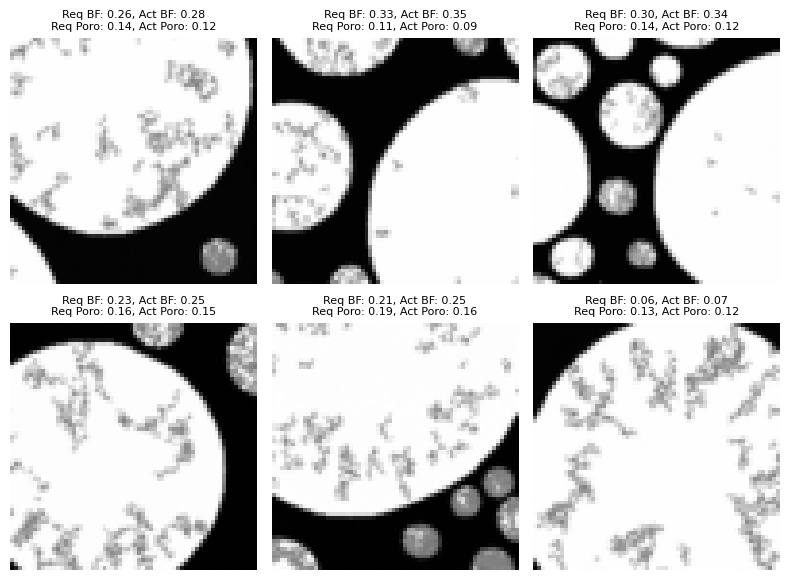

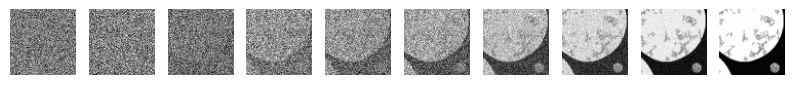

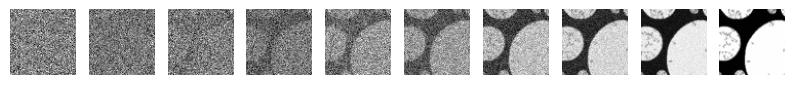

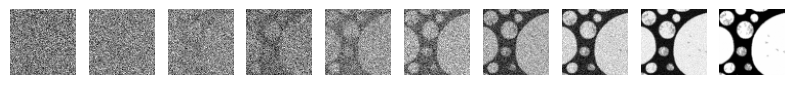

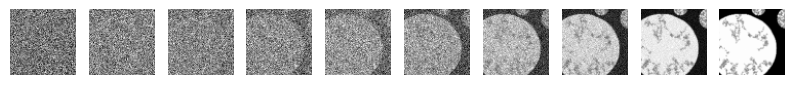

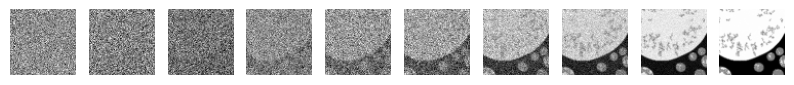

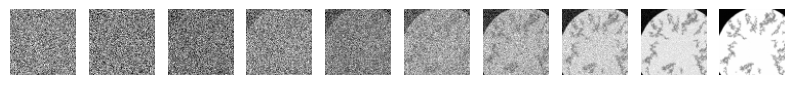

In [27]:
inference('checkpoints/binary_circles_4.1')


In [23]:
def inference_one(binder_fraction: float, checkpoint_path: str = None,
                                        num_time_steps: int = 1000,
                                        ema_decay: float = 0.9999):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0, 15, 50, 100, 200, 300, 400, 550, 700, 999]
    final_images = [] 
    reverse_images = []  
    actual_binder_fractions = []  

    with torch.no_grad():
        model = ema.module.eval()
        requested_binder_fraction = binder_fraction
        binder_fraction_tensor = torch.tensor([requested_binder_fraction], dtype=torch.float32).cuda()

        z = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
        reverse_steps = [] 
        for t in reversed(range(1, num_time_steps)):
            t = [t]
            temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
            z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), t).cpu())
            if t[0] in times:
                reverse_steps.append(z.clone()) 
            e = torch.randn(1, 1, IMG_SIZE, IMG_SIZE)
            z = z + (e * torch.sqrt(scheduler.beta[t]))
        temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
        x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z.cuda(), binder_fraction_tensor.unsqueeze(-1), [0]).cpu())

        final_images.append(x.clone())  
        reverse_steps.append(x) 
        reverse_images.append(reverse_steps) 

        actual_binder_fraction = calculate_binder_fraction(x.cpu())
        actual_binder_fractions.append(actual_binder_fraction)

    x = rearrange(final_images[0].squeeze(0), 'c h w -> h w c').detach().numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(x, cmap='gray')
    actual = actual_binder_fractions[0]
    plt.title(f"Requested: {binder_fraction:.2f}, Actual: {actual:.2f}", fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    for reverse_steps in reverse_images:
        display_reverse(reverse_steps)

In [ ]:
inference_one(0.1, 'checkpoints/binary_circles_4.1')
